# This notebook computes the Non-Guassian covariance contributions to the S/N of primordial Bispectra

In [1]:
import numpy as np
from powerspectrum import *
from bispectra import *
from SecondaryPolyspectra import *
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
import vegas
from joblib import Parallel, delayed
%matplotlib inline

plt.rcParams.update({'font.size': 13})
plt.style.use('seaborn-colorblind')

In [2]:
print(h,As,ns)

0.6711 2.13e-09 0.9624


In [3]:
kF = 2.*np.pi / 1000.
kF

0.006283185307179587

In [4]:
#these are the redshifts we consider
zs = [0,3,10,30,50,100]

#load the linear powerspectrum
PLindat = np.genfromtxt("PLinear.dat")
kPLin = PLindat[:,0]
PLindata = PLindat[:,1:]

In [5]:
#load the non-linear power spectrum as obtained from CAMB/HALOFIT
PNonLindat = np.genfromtxt("PHalo.dat")
kPNonLin = PNonLindat[:,0]
PNonLindata = PNonLindat[:,1:]

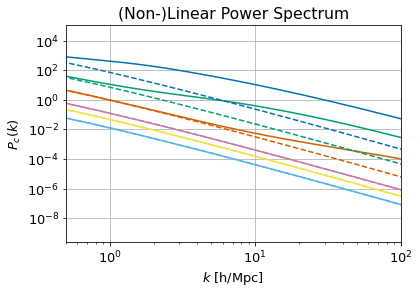

In [6]:
#plot the (non-)linear power spectra for different redshifts
plt.loglog(kPNonLin,PNonLindata[:,:])
plt.gca().set_prop_cycle(None)
plt.loglog(kPLin,PLindata[:,:],"--")
plt.xlim(kPLin[0],300)
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$P_c(k)$")
plt.title("(Non-)Linear Power Spectrum")
plt.grid()
# plt.legend([f"z={zi}" for zi in zs],loc='lower left')
plt.xlim(5e-1,100)

plt.show()

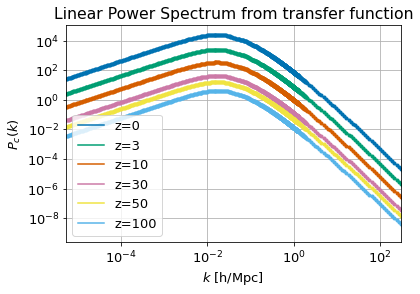

In [7]:
transfer_data = np.genfromtxt("LinearTransfer.dat")
kh_transfer = transfer_data[:,0]
Tc = transfer_data[:,1:]
k_transfer = kh_transfer*h
Pprim = P(k_transfer)

plt.loglog(kPLin,PLindata[:,:])
plt.gca().set_prop_cycle(None)
plt.loglog(kh_transfer,Pprim[:,np.newaxis] * Tc**2,".")
plt.xlim(kPLin[0],300)
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$P_c(k)$")
plt.title("Linear Power Spectrum from transfer function")
plt.grid()
plt.legend([f"z={zi}" for zi in zs],loc='lower left')
plt.show()

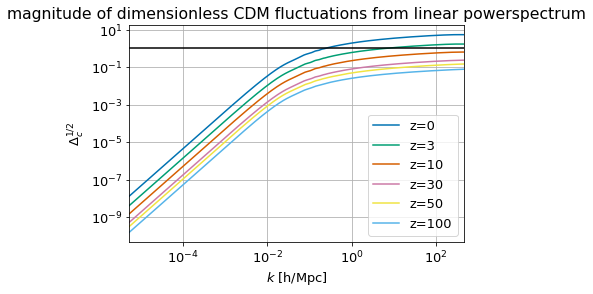

In [8]:
#plot the magnitdue of dimensionless fluctuations, to have an idea of the non-linear scale
plt.loglog(kPLin,np.sqrt(PLindata *kPLin[:,np.newaxis]**3/(2*np.pi**2)))
plt.xlim(kPLin[0],kPLin[-1])
plt.hlines(1,kPLin[0],kPLin[-1],"k")
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$\\Delta_c^{1/2}$")
plt.title("magnitude of dimensionless CDM fluctuations from linear powerspectrum")
plt.grid()
plt.legend([f"z={zi}" for zi in zs],loc='lower right')
# plt.savefig("dimless.pdf",format='pdf')
plt.show()

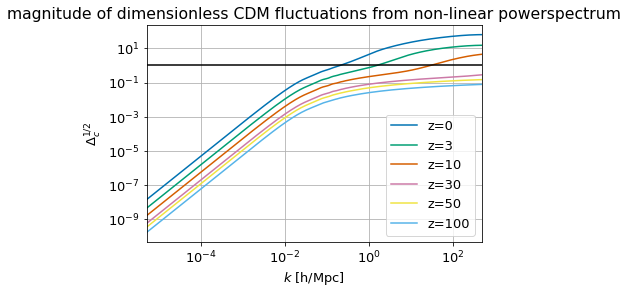

In [9]:
#plot the magnitdue of dimensionless fluctuations, to have an idea of the non-linear scale
plt.loglog(kPNonLin,np.sqrt(PNonLindata *kPNonLin[:,np.newaxis]**3/(2*np.pi**2)))
plt.xlim(kPNonLin[0],kPNonLin[-1])
plt.hlines(1,kPNonLin[0],kPNonLin[-1],"k")
plt.xlabel("$k$ [h/Mpc]")
plt.ylabel("$\\Delta_c^{1/2}$")
plt.title("magnitude of dimensionless CDM fluctuations from non-linear powerspectrum")
plt.grid()
plt.legend([f"z={zi}" for zi in zs],loc='lower right')
# plt.savefig("dimless.pdf",format='pdf')
plt.show()

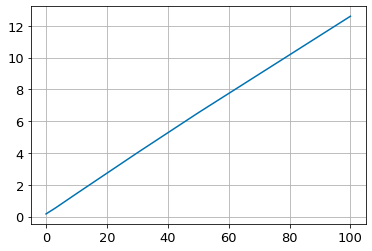

[0.16703188015479575,
 0.529528012092672,
 1.4412561903182293,
 4.011010995275974,
 6.524101562290968,
 12.59494786399624]

In [10]:
kNLs = [(np.trapz(PLindata[:,i],kPLin)/6/np.pi**2)**-.5 for i in range(len(zs))]
plt.plot(zs,kNLs)
plt.grid()
# plt.xlim(0,6)
# plt.ylim(0,1)
plt.show()
kNLs

# First we calculate the Gaussian covariance

In [11]:
def GaussIntegrand(k,kmin,kmax,TFint,PNonLinInt,BShape,BShape2):
    result = np.zeros((len(k)))

    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    theta = k[:,2]

    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    dVol = 2*np.pi * 4*np.pi * k1**2 * k2**2 * (kmax-kmin) * (kmax-kmin) * np.sin(theta)

    TF1 = TFint(k1)
    TF2 = TFint(k2)
    TF3 = TFint(k3)
    
    P1prim = P(k1*h)
    P2prim = P(k2*h)
    P3prim = P(k3*h)
    
    P1 = TF1**2 * P1prim
    P2 = TF2**2 * P2prim
    P3 = TF3**2 * P3prim
    
    bools = k1 < kmin
    bools+= k2 < kmin
    bools+= k3 < kmin
    
    bools+= k1 > kmax
    bools+= k2 > kmax
    bools+= k3 > kmax
    
    P1NL = PNonLinInt(k1)
    P2NL = PNonLinInt(k2)
    P3NL = PNonLinInt(k3)

    W1 = TF1*TF2*TF3*BShape(P1prim,P2prim,P3prim)/6/P1/P2/P3
#     W1 = TF1*TF2*TF3*BShape(P1prim,P2prim,P3prim)/(2*(P1NL*P2*P3 + P1*P2NL*P3 + P1*P2*P3NL))
    if BShape2 == None:
        W2 = W1
    else:
        W2 = TF1*TF2*TF3*BShape2(P1prim,P2prim,P3prim)/6/P1/P2/P3
#         W2 = TF1*TF2*TF3*BShape2(P1prim,P2prim,P3prim)/(2*(P1NL*P2*P3 + P1*P2NL*P3 + P1*P2*P3NL))

    result = W1*W2 * 6 * P1 * P2 * P3 / (2*np.pi)**3 / kF**3
    result[bools] = 0
    result *= dVol
    
    return result

def Gauss(kmin,kmax,zn,BShape,BShape2=None,rtol=1e-3,verbose=0):
    z = zs[zn]
    TFint = interpolate(kh_transfer,Tc[:,zn])
    PNonLinInt = interpolate(kPNonLin,PNonLindata[:,zn])
    
#     print("z",zn,zs[zn])

    @vegas.batchintegrand
    def integrandbatch(k):
        return GaussIntegrand(k,kmin,kmax,TFint,PNonLinInt,BShape,BShape2)

    integ = vegas.Integrator([[0,1],[0,1],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zn,zs[zn])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zn, Q, mean, rerr

%time Gauss(kF,kNLs[0],0,BLocal,rtol=1e-3,verbose=1)

z 0 0
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.004364(31)    0.004364(31)        0.00     1.00
  2   0.0042984(43)   0.0042997(43)       4.42     0.04

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0042963(40)   0.0042963(40)       0.00     1.00

CPU times: user 345 ms, sys: 197 ms, total: 542 ms
Wall time: 1.11 s


(0, nan, 0.0042963143637947945, 0.0009239575204394956)

### This is equal to the usual (S/N)^2 with Gaussain covariance since  $\langle N^2 \rangle = \langle S \rangle $ (See Notes)

# We now calculate the non-Gaussian Covariance

### First the P*T contribution

In [35]:
def NonGaussIntegrandT(k,kmin,kmax,TFint,PNonLinInt,BShape):
    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    phik2 = k[:,2]
    thetak2 = k[:,3]
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(thetak2))
    q1 = k1
    q2 = kmin + k[:,4] * (kmax-kmin)
    phiq2 = k[:,5]
    thetaq2 = k[:,6]
    q3 = np.sqrt(k1**2 + q2**2 - 2*k1*q2*np.cos(thetaq2))
    K12 = k1
    K13 = np.sqrt(k2**2 + q2**2 + 2*k2*q2*(np.cos(thetak2)*np.cos(thetaq2) + np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    K14 = np.sqrt(k1**2 + k2**2 + q2**2 + 2*k2*np.cos(thetak2)*(k1 - q2*np.cos(thetaq2)) - 2*q2*(k1*np.cos(thetaq2) + k2*np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    
    #4pi comes from integrating out the k1 angles
    #2*2 from symmetry that allows to half the polar angles of k2 and q2
    dVol = 2*2 * 4*np.pi * k1**2 * k2**2 * q2**2 * (kmax-kmin) * (kmax-kmin)* (kmax-kmin) * np.sin(thetak2) * np.sin(thetaq2)
    
    bools = k1 < kmin
    bools+= k2 < kmin
    bools+= k3 < kmin
    bools+= q1 < kmin
    bools+= q2 < kmin
    bools+= q3 < kmin
    bools+= K12< kmin
    bools+= K13< kmin
    bools+= K14< kmin
    bools+= k1 > kmax
    bools+= k2 > kmax
    bools+= k3 > kmax
    bools+= q1 > kmax
    bools+= q2 > kmax
    bools+= q3 > kmax
    bools+= K12> 2*kmax
    bools+= K13> 2*kmax
    bools+= K14> 2*kmax 

    TFk1 = TFint(k1)
    TFk2 = TFint(k2)
    TFk3 = TFint(k3)
    TFq1 = TFint(q1)
    TFq2 = TFint(q2)
    TFq3 = TFint(q3)
    TF12 = TFint(K12)
    TF13 = TFint(K13)
    TF14 = TFint(K14)
    
    Pk1prim = P(k1*h)
    Pk2prim = P(k2*h)
    Pk3prim = P(k3*h)
    Pq1prim = P(q1*h)
    Pq2prim = P(q2*h)
    Pq3prim = P(q3*h)
    P12prim = P(K12*h)
    P13prim = P(K13*h)
    P14prim = P(K14*h)
    
    Pk1 = TFk1**2 * Pk1prim
    Pk2 = TFk2**2 * Pk2prim
    Pk3 = TFk3**2 * Pk3prim
    Pq1 = TFq1**2 * Pq1prim
    Pq2 = TFq2**2 * Pq2prim
    Pq3 = TFq3**2 * Pq3prim
    P12 = TF12**2 * P12prim
    P13 = TF13**2 * P13prim
    P14 = TF14**2 * P14prim
    
    Pk1NL = PNonLinInt(k1)
    Pk2NL = PNonLinInt(k2)
    Pk3NL = PNonLinInt(k3)
    Pq1NL = PNonLinInt(q1)
    Pq2NL = PNonLinInt(q2)
    Pq3NL = PNonLinInt(q3)
    
    W1 = TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/6/Pk1/Pk2/Pk3
#     W1 = TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/(2*(Pk1NL*Pk2*Pk3 + Pk1*Pk2NL*Pk3 + Pk1*Pk2*Pk3NL))
    W2 = TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/6/Pq1/Pq2/Pq3
#     W2 = TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/(2*(Pq1NL*Pq2*Pq3 + Pq1*Pq2NL*Pq3 + Pq1*Pq2*Pq3NL))
    T = TSec(k2,k3,q2,q3,K12,K13,K14,Pk2,Pk3,Pq2,Pq3,P12,P13,P14) ## gives back all permutations already
    
    result = 9 * W1 * W2 * Pk1 * T / (2*np.pi)**6 / kF**3
    result[bools] = 0
    result *= dVol

    return result

def NonGaussT(kmin,kmax,zn,BShape,rtol=1e-3,verbose=0):
    z = zs[zn]
    TFint = interpolate(kh_transfer,Tc[:,zn])
    PNonLinInt = interpolate(kPNonLin,PNonLindata[:,zn])

    @vegas.batchintegrand
    def integrandbatch(k):
        return NonGaussIntegrandT(k,kmin,kmax,TFint,PNonLinInt,BShape)
    
    integ = vegas.Integrator([[0,1],[0,1],[0,np.pi],[0,np.pi],[0,1],[0,np.pi],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zn,zs[zn])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zn, Q, mean, rerr

%time NonGaussT(kF,kNLs[0],0,BLocal,rtol=1e-2,verbose=1)

z 0 0
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.03290(27)     0.03290(27)         0.00     1.00

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.03300(11)     0.03300(11)         0.00     1.00

CPU times: user 837 ms, sys: 1.99 ms, total: 839 ms
Wall time: 834 ms


(0, nan, 0.03299673647672731, 0.003414214511683222)

### Then the B*B contribution

In [13]:
def NonGaussIntegrandBB(k,kmin,kmax,TFint,PNonLinInt,BShape):
    k1 = kmin + k[:,0] * (kmax-kmin)
    k2 = kmin + k[:,1] * (kmax-kmin)
    phik2 = k[:,2]
    thetak2 = k[:,3]
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(thetak2))
    q1 = k3
    q2 = kmin + k[:,4] * (kmax-kmin)
    phiq2 = k[:,5]
    thetaq2 = k[:,6]
    q3 = np.sqrt(k1**2 + k2**2 + q2**2 + 2*k2*np.cos(thetak2)*(k1 - q2*np.cos(thetaq2)) - 2*q2*(k1*np.cos(thetaq2) + k2*np.cos(phik2 - phiq2)*np.sin(thetak2)*np.sin(thetaq2)))
    
    #4*pi comes from integrating out the k1 angles
    dVol = 4*np.pi * k1**2 * k2**2 * q2**2 * (kmax-kmin) * (kmax-kmin)* (kmax-kmin) * np.sin(thetak2) * np.sin(thetaq2)

    bools = k1 < kmin
    bools+= k2 < kmin
    bools+= k3 < kmin
    bools+= q1 < kmin
    bools+= q2 < kmin
    bools+= q3 < kmin
    bools+= k1 > kmax
    bools+= k2 > kmax
    bools+= k3 > kmax
    bools+= q1 > kmax
    bools+= q2 > kmax
    bools+= q3 > kmax

    TFk1 = TFint(k1)
    TFk2 = TFint(k2)
    TFk3 = TFint(k3)
    TFq1 = TFint(q1)
    TFq2 = TFint(q2)
    TFq3 = TFint(q3)
    
    Pk1prim = P(k1*h)
    Pk2prim = P(k2*h)
    Pk3prim = P(k3*h)
    Pq1prim = P(q1*h)
    Pq2prim = P(q2*h)
    Pq3prim = P(q3*h)
    
    Pk1 = TFk1**2 * Pk1prim
    Pk2 = TFk2**2 * Pk2prim
    Pk3 = TFk3**2 * Pk3prim
    Pq1 = TFq1**2 * Pq1prim
    Pq2 = TFq2**2 * Pq2prim
    Pq3 = TFq3**2 * Pq3prim
    
    Pk1NL = PNonLinInt(k1)
    Pk2NL = PNonLinInt(k2)
    Pk3NL = PNonLinInt(k3)
    Pq1NL = PNonLinInt(q1)
    Pq2NL = PNonLinInt(q2)
    Pq3NL = PNonLinInt(q3)

    W1 = TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/6/Pk1/Pk2/Pk3
#     W1 = TFk1*TFk2*TFk3*BShape(Pk1prim,Pk2prim,Pk3prim)/(2*(Pk1NL*Pk2*Pk3 + Pk1*Pk2NL*Pk3 + Pk1*Pk2*Pk3NL))
    W2 = TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/6/Pq1/Pq2/Pq3
#     W2 = TFq1*TFq2*TFq3*BShape(Pq1prim,Pq2prim,Pq3prim)/(2*(Pq1NL*Pq2*Pq3 + Pq1*Pq2NL*Pq3 + Pq1*Pq2*Pq3NL))
    
    BS1 = Pk1*Pk2*BSec(k1,k2,k3)+Pk1*Pk3*BSec(k1,k3,k2)+Pk2*Pk3*BSec(k2,k3,k1)
    BS2 = Pq1*Pq2*BSec(q1,q2,q3)+Pq1*Pq3*BSec(q1,q3,q2)+Pq2*Pq3*BSec(q2,q3,q1)
    
    result = 9*W1*W2*BS1*BS2 / (2*np.pi)**6 / kF**3
    result[bools] = 0
    result *= dVol
    
    return result

def NonGaussBB(kmin,kmax,zn,BShape,rtol=1e-3,verbose=0):
    z = zs[zn]
    TFint = interpolate(kh_transfer,Tc[:,zn])
    PNonLinInt = interpolate(kPNonLin,PNonLindata[:,zn])


    @vegas.batchintegrand
    def integrandbatch(k):
        return NonGaussIntegrandBB(k,kmin,kmax,TFint,PNonLinInt,BShape)

    integ = vegas.Integrator([[0,1],[0,1],[0,2*np.pi],[0,np.pi],[0,1],[0,2*np.pi],[0,np.pi]])
    
    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    if verbose!=0:
        print("z",zn,zs[zn])
        print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e5,rtol=rtol)
    if verbose!=0:
        print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    Q = results.Q

    return zn, Q, mean, rerr

%time NonGaussBB(kF,kNLs[0],0,BLocal,rtol=1e-3,verbose=1)

z 0 0
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.0269(13)      0.0269(13)          0.00     1.00
  2   0.02617(27)     0.02621(26)         0.32     0.57
  3   0.02568(22)     0.02590(17)         1.33     0.27
  4   0.02608(14)     0.02601(11)         1.12     0.34
  5   0.02609(13)     0.026041(85)        0.91     0.46
  6   0.02565(12)     0.025916(70)        2.10     0.06
  7   0.02623(14)     0.025978(63)        2.42     0.02
  8   0.02592(12)     0.025967(56)        2.09     0.04
  9   0.02587(12)     0.025950(50)        1.90     0.06
 10   0.02603(12)     0.025962(47)        1.73     0.08

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.02587(11)     0.02587(11)         0.00     1.00
  2   0.02590(13)     0.025882(84)        0.05     0.83
  3   0.02583(12)     0.025864(68)        0.09     0.91
  4   0.02606(14)     0.025903(61)       

(0, 0.2492897230863472, 0.025880870342310923, 0.000978901421275751)

## Now make some plots of the loss of signal-to-noise as a function of kmax, for the different primordial bispectra

In [14]:
kmin = kF
kmaxlow = kmin*1.1
kmaxhigh = kNLs

# print(kmin,kmaxlow,kmaxhigh)

zns = [0,1,2,3,4,5]

kmaxs = np.logspace(np.log10(kmaxlow),np.log10(kmaxhigh),36)
BShapes = [BLocal,BEquil,BOrtho]
ShapeLabels=["Local","Equil","Ortho"]

tasks = [delayed(Gauss)(kmin,kmax,zi,BS,rtol=0.01) for BS in BShapes for zi in zns for kmax in kmaxs[:,zi]]
GaussDat = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))

tasks = [delayed(NonGaussT)(kmin,kmax,zi,BS,rtol=0.01) for BS in BShapes for zi in zns for kmax in kmaxs[:,zi]]
NonGaussTDat = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))

tasks = [delayed(NonGaussBB)(kmin,kmax,zi,BS,rtol=0.01) for BS in BShapes for zi in zns for kmax in kmaxs[:,zi]]
NonGaussBDat = np.array(Parallel(n_jobs=-1,verbose=1)(tasks))

Gaussian = np.zeros((len(BShapes),len(zns),len(kmaxs)))
NonGaussianT = np.zeros((len(BShapes),len(zns),len(kmaxs)))
NonGaussianB = np.zeros((len(BShapes),len(zns),len(kmaxs)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:   17.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  1.5min finishe

In [15]:
Gaussian = GaussDat[:,-2].reshape((len(BShapes),len(zns),len(kmaxs)))
NonGaussianT = NonGaussTDat[:,-2].reshape((len(BShapes),len(zns),len(kmaxs)))
NonGaussianB = NonGaussBDat[:,-2].reshape((len(BShapes),len(zns),len(kmaxs)))

SN2G = Gaussian
SN2NG= Gaussian**2 / (Gaussian + NonGaussianB + NonGaussianT)

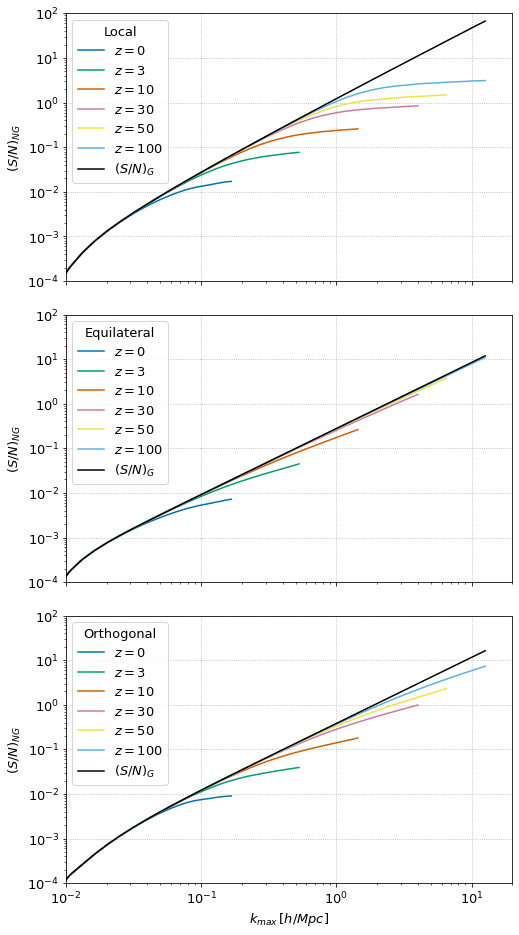

In [17]:
fig, axs = plt.subplots(3,1,sharex=True,figsize=(8,16))
plt.subplots_adjust(wspace=0, hspace=0.125)

ShapeLabels=["Local","Equilateral","Orthogonal"]

for si in range(len(BShapes)):
        
    plt.gca().set_prop_cycle(None)
        
    [axs[si].loglog(kmaxs[:,zi], SN2NG[si,zi]**.5) for zi in range(len(zns))] #Both P*T and B*B
    axs[si].loglog(kmaxs[:,-1], SN2G[si,-1]**.5,"-k")
    axs[si].set_ylabel("$(S/N)_{NG}$")

    axs[si].grid(linestyle=":")
    plt.xlim(1e-2,2e1)
    labels = np.array(["$z=$" + f"${zs[zi]}$" for zi in zns])
    labels = np.append(labels,["$(S/N)_{G}$"])
    
#     plt.legend(labels,title=ShapeLabels[si])
    axs[si].legend(labels,title=ShapeLabels[si],loc=0)
    axs[si].set_ylim(1e-4,1e2)
#     plt.title(ShapeLabels[si])
plt.xlabel("$k_{max}\,[h/Mpc]$")

plt.savefig(f"Results/SN_BS.pdf",format='pdf',bbox_inches='tight')
plt.show()